In [1]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, \
balanced_accuracy_score, accuracy_score
from sklearn import metrics
import math

In [2]:
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'

In [3]:
os.chdir(os.environ.get('USER_PATH'))

In [4]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy, get_recomb_rate, interpolate_genetic_pos, form_windows
from src.utils.modelUtil import Params, load_model
from src.utils.labelUtil import nearestNeighbourMapping, repeat_pop_arr
from src.utils.decorators import timer
from src.models import AuxiliaryTask, LSTM, Attention, BasicBlock, Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix, \
getCpPred
import inference

# load the model and use valid data 

In [5]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_3_pca')
data_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_3_pca')
models_path=osp.join(os.environ['OUT_PATH'],'humans/training/Model_B_exp_id_11_data_id_3_pca/') 
dataset_type='valid'

In [13]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=False
json_path = osp.join(config['models.dir'], 'params.json')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=True
params.mc_samples=100
params.cp_tol=1
params.balancedLoss=False
results, valid_dataset,_,_=inference.main(config, params)

 device used: cuda
Loading the datasets...
Finished 'transform_data' in 27.3709 secs
Finished '__init__' in 33.1825 secs
model ['Model_B.model_B'] : AuxiliaryTask.AuxNetwork
model ['Model_B.model_B'] : LSTM.BiRNN
model ['Model_B.model_B'] : BasicBlock.logits_Block
best val loss metrics : {'gcd': None, 'mse': 0.20385380191340585, 'smooth_l1': 0.09717841084952034, 'weighted_loss': 0.3457071813150901, 'loss_main': 0.3457071813150901, 'loss_aux': 0.8641278095425867}
at epoch : 112
train loss metrics: {'gcd': None, 'mse': 0.10245460406677359, 'smooth_l1': 0.04928272137641228, 'weighted_loss': 0.24640625585042975, 'loss_main': 0.22746289233439268, 'loss_aux': 0.9102970728931684}
best val cp metrics : {'loss_cp': 0.07141693137653407, 'prMetrics': OrderedDict([('Precision', array(0.80763529)), ('Recall', array(0.41389135)), ('Accuracy', array(0.99065382)), ('A_major', array(0.99863571)), ('BalancedAccuracy', 0.7062635323904036)])}
train cp metrics: {'loss_cp': 0.20447060657562408, 'prMetrics':

In [14]:
results.t_accr, results.t_cp_accr

({'gcd': None,
  'loss_aux': 0.8932564749119528,
  'loss_main': 0.3306829041933149,
  'mse': 0.1720936282936671,
  'smooth_l1': 0.0827654607555313,
  'weighted_loss': 0.3306829041933149},
 {'loss_cp': 0.21637593229414243,
  'prMetrics': OrderedDict([('Precision', array(0.0407651)),
               ('Recall', array(0.89464354)),
               ('Accuracy', array(0.71120176)),
               ('A_major', array(0.70866309)),
               ('BalancedAccuracy', 0.8016533112523417)])})

In [15]:
results.t_out.coord_main=results.t_out.coord_main.mean(0)

In [16]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
data_tensor = torch.tensor(y_pred).float()
batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
_,_,_,_=model_cpd.run_recursive(data_tensor, 'cpu')

Finished 'run_recursive' in 209.6635 secs


In [17]:
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
superop_dict=load_path(osp.join(labels_path, 'superpop.pkl'), en_pickle=True)
pop_sample_map=pd.read_csv(osp.join(labels_path, 'pop_sample_map.tsv'),sep="\t")
pop_arr=repeat_pop_arr(pop_sample_map)
cp_target=valid_dataset.data['cps']
seqlen=cp_target.shape[1]
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}
rev_sp_dict={v:k for k,v in superop_dict.items()}

In [18]:
# index = 2500
# index=2620
index=2650
# index=3000
# index=3100
# index=2134
# index=np.random.choice(idxOfInterest)
print(index)
true_cpsSample=cp_target[index,:].detach().cpu().numpy()
y_predSample=results.t_out.coord_main[index,:]
y_trueSample=valid_dataset.data['y'][index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:]
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
superPopSample=valid_dataset.data['superpop'][index,:]
SpNamesSample=[rev_sp_dict[i] for i in superPopSample.astype(int)]

2650


In [19]:
y_predSample.shape

(317, 3)

In [20]:
pred_cps=getCpPred(cpMethod.gradient.name, y_predSample, 0.1, 1, len(true_cpsSample))
pred_cps=pred_cps.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [21]:
predBOCDSample=model_cpd.cp[index,:]
pred_cps_BOCD=getCpPred(cpMethod.BOCD.name, predBOCDSample, 5.0, 1, len(true_cpsSample))
pred_cps_BOCD=pred_cps_BOCD.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [22]:
cpIdx=np.nonzero(pred_cps_BOCD)[0]
remWin=3
for i in cpIdx:
    low=max(0,i-remWin)
    high=min(seqlen, i+remWin)
    pred_cps_BOCD[low:high]=1

In [23]:
mappedSpArr=nearestNeighbourMapping(labels_path, y_predSample.reshape(-1,3))

Finished 'getSuperpopBins' in 0.0730 secs


In [24]:
mappedSpArr.shape

(317,)

In [25]:
y_predsTrue=valid_dataset.data['y'].detach().cpu().numpy().reshape(-1,3)
superpopsTrue=valid_dataset.data['superpop'].detach().cpu().numpy().reshape(-1,)

In [138]:
@timer
def plot_sample(granularPopSample, y_predSample, y_trueSample, **kwargs):
    backgroundAxis=kwargs.get('backgroundAxis')
    y_predCps=kwargs.get('y_predCps')
    y_preds=kwargs.get('y_preds')
    superpops=kwargs.get('superpops')
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps')
    mappedSpArr=kwargs.get('mappedSpArr')
    superPopSample=kwargs.get('superPopSample')
    
    
    fig, ax = plt.subplots(figsize=(12,14))
    plt.rcParams['hatch.color']='grey'
    
    gs1 = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[13,1,1])
    ax1=fig.add_subplot(gs1[0],projection='3d')
    ax1.set_xlim(np.array([-2,2])*.77)
    ax1.set_ylim(np.array([-2,2])*.77)
    ax1.set_zlim(np.array([-2,2])*.77)
    ax2=fig.add_subplot(gs1[1])
    ax3=fig.add_subplot(gs1[2])
    for axis in [ax, ax2, ax3]:
        axis.set_yticks([])
        axis.spines['top'].set_color('none')
        axis.spines['left'].set_color('none')
        axis.spines['right'].set_color('none')
    ax.set_xticks([])
    fig.subplots_adjust(left=0, right=0.5, bottom=0, top=0.5)
    plt.subplots_adjust(hspace=0.01)
    
    if backgroundAxis:
        lgnd, colorsPop_sp_dict =plot_all(ax1, y_preds, superpops, cpShow=False)
    else:
        continentaPops=list(superop_dict.values())
        colorsPop_sp = sns.color_palette("bright", 10)
        del colorsPop_sp[1]
        del colorsPop_sp[4]
        del colorsPop_sp[5]
        colorsPop_sp_dict = {k:v for k,v in zip(continentaPops, colorsPop_sp)}
        patches=[]
        for k, val in superop_dict.items():
            patches.append(mpatches.Patch(color = colorsPop_sp_dict[val], label = k))
        lgnd = ax1.legend(handles=patches, loc="upper right", fontsize=15, bbox_to_anchor=(-0.15, 0.49, 1., .5))

    ax1.add_artist(lgnd)
    #colors_pop = sns.color_palette("rainbow", len(np.unique(granularPopSample)))
    #colors_pop_dict = {k:v for k,v in zip(np.unique(granularPopSample), colors_pop)}
    colors_Gp_dict,_,_=getColorsPop(granularpopSample, superPopSample, colorsPop_sp_dict)
    colors_pop_dict=colors_Gp_dict

    alpha=[1]*len(y_predSample)
    if cpShow is None:
        #alpha=(pred_cps==0).astype(float)
        unknownIdx=np.nonzero(pred_cps)[0]
        granularPopNames=["UNK" if i in unknownIdx else granularPopSample[i] for i in range(len(granularPopSample))]
        colors_pop_dict["UNK"]=(0.9,0.9,0.9) # grey color
        mappedSpArr[unknownIdx]=-1
        colorsPop_sp_dict[-1]=(0.9,0.9,0.9) # grey color
        knownIdx=[i for i in range(len(granularPopNames)) if granularPopNames[i]!="UNK"]
        
    ax1.scatter(y_predSample[knownIdx,0], y_predSample[knownIdx,1], y_predSample[knownIdx,2],\
    color = [tuple(colors_pop_dict[x])+(y,) for x,y in zip([granularPopNames[i] for i in knownIdx], alpha)], s=50, zorder=0)
    
    ax1.scatter(y_predSample[unknownIdx,0], y_predSample[unknownIdx,1], y_predSample[unknownIdx,2], facecolor='grey', hatch=3*'+',\
    color = [tuple(colors_pop_dict[x])+(y,) for x,y in zip([granularPopNames[i] for i in unknownIdx], alpha)], s=50, zorder=0) 
    
    #ToDo: plot only the unique trueSample instead of all the windows
    ax1.scatter(y_trueSample[:,0], y_trueSample[:,1], y_trueSample[:,2], linewidth=1, \
    color = [tuple(colors_pop_dict[x]) for x in granularPopSample], marker='X', s=200, zorder=0)
    
    for axis in [ax1.xaxis, ax1.yaxis, ax1.zaxis]:
        axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        axis._axinfo["grid"]['color'] = (1,1,1,0)
    patches=[]
    for i, val in enumerate(np.unique(granularPopSample)):
        patches.append(mpatches.Patch(color = colors_pop_dict[val], label = rev_pop_dict[val]))
    patches.append(mpatches.Patch(facecolor = (0.9,0.9,0.9), label = "Changepoint", hatch=3*'+')) #add UNK legend patch separately
    ax1.legend(handles=patches, loc="upper left", fontsize=20)
    
    #chm plot ground truth
    ax2.bar(np.arange(len(y_trueSample)),\
    color=[colors_pop_dict[x] for x in granularPopSample], width=1.0, height=1.02)
    ax2.set_title('Labeled Chromosome22', fontsize=30, y=0.3)
    
    #chm plot of predictions
    ax3.bar(knownIdx, 1.02*np.ones(len(mappedSpArr[knownIdx])), \
            color=[colorsPop_sp_dict[x]+(y,) for x,y in zip(mappedSpArr[knownIdx],alpha)], \
            width=1.0)
    ax3.bar(unknownIdx, 1.02*np.ones(len(mappedSpArr[unknownIdx])), \
        color=[colorsPop_sp_dict[x]+(y,) for x,y in zip(mappedSpArr[unknownIdx],alpha)], \
        width=1.0, hatch=3*"+")
    ax3.set_title('Predicted Chromosome22', fontsize=30, y=0.3)
    
    for ax in [ax2, ax3]:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(4))
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(which='major', width=2, length=10, labelsize=25)
        ax.tick_params(which='minor', width=2, length=6, labelsize=10)
        ax.set_xlim(0, 316)
        ax.set_ylim(0.99,1.09)
        positions = [0, 160, 300]
        x_labels = [0, 150000, 317000]
        ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_labels))
    
    plt.tight_layout(pad=0.4, w_pad=0.3, h_pad=0.3)
    plt.show()
    plt.close('all')

Finished 'plot_all' in 14.4158 secs


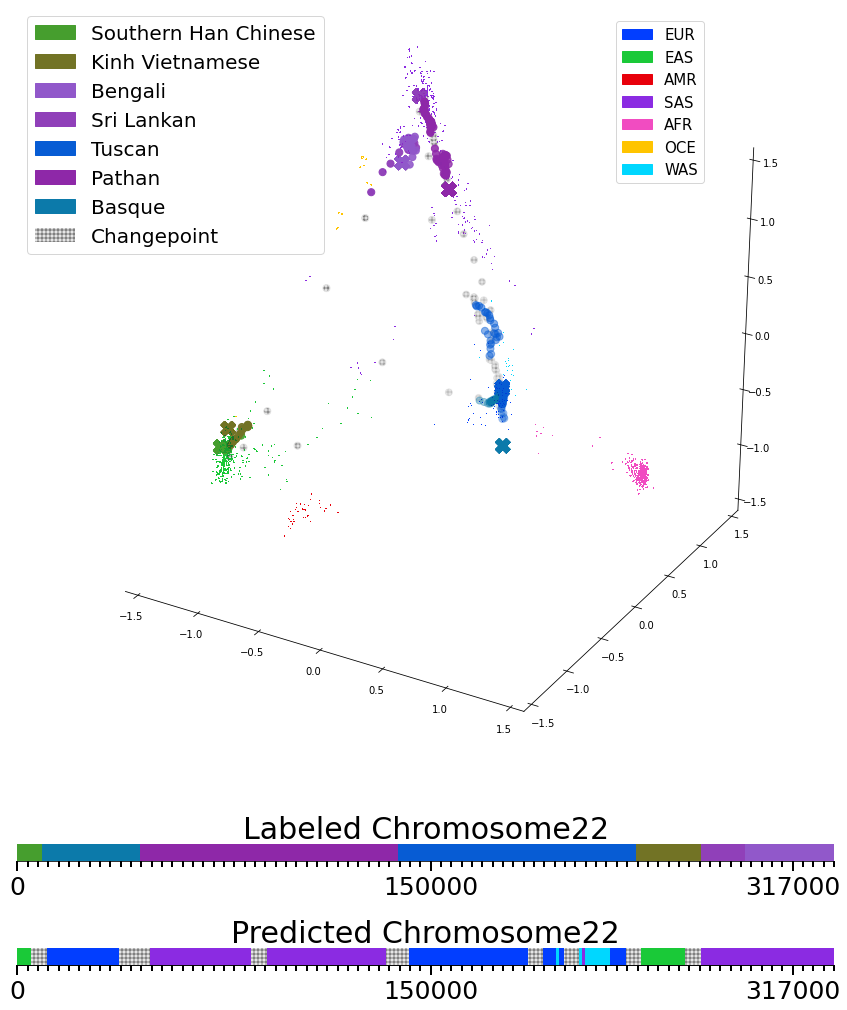

Finished 'plot_sample' in 28.4312 secs


In [158]:
plot_sample(granularpopSample, y_predSample, y_trueSample, pred_cps=pred_cps_BOCD, mappedSpArr=mappedSpArr, \
backgroundAxis=True, y_preds=y_predsTrue, superpops=superpopsTrue, superPopSample=superPopSample)

In [155]:
@timer
def plot_all(ax, y_preds, superpops, **kwargs):
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps')    
    continentaPops=list(superop_dict.values())
    colors_pop = sns.color_palette("bright", 10)
    del colors_pop[1]
    del colors_pop[4]
    del colors_pop[5]
    colors_pop_dict = {k:v for k,v in zip(continentaPops, colors_pop)}
    
    alpha=[0.03]*len(y_preds)
    if cpShow is None:
        alpha=(pred_cps==0).astype(float)
    
    ax.scatter(y_preds[:,0], y_preds[:,1], y_preds[:,2], \
               color = [colors_pop_dict[x]+(y,) for x,y in zip(superpops, alpha)], marker=".", s=0.05,zorder=-1) 
    
    patches=[]
    for k, val in superop_dict.items():
        patches.append(mpatches.Patch(color = colors_pop_dict[val], label = k))
    lgnd = ax.legend(handles=patches, loc="upper right", fontsize=15, bbox_to_anchor=(-0.15, 0.49, 1., .5))
    return lgnd, colors_pop_dict


In [28]:
y_preds=results.t_out.coord_main
y_predCps=getCpPred(cpMethod.gradient.name, y_predSample, 0.1, y_preds.shape[0], y_preds.shape[1])
y_predCps=y_predCps.detach().cpu().numpy().reshape(-1,)
y_preds=y_preds.reshape(-1,3)
superpops=valid_dataset.data['superpop'].detach().cpu().numpy().reshape(-1,)

In [29]:
# lgnd, _=plot_all(y_preds, superpops, pred_cps=y_predCps)

In [30]:
superop_dict

{'AFR': 4, 'AMR': 2, 'EAS': 1, 'EUR': 0, 'OCE': 5, 'SAS': 3, 'WAS': 6}

In [31]:
def linear_gradient(start_rgb, finish_rgb, n):
    ''' returns a gradient list of (n) colors between
      two rgb colors. start_rgb and finish_rgb
       '''
    # Initilize a list of the output colors with the starting color
    RGB_list = [start_rgb]
    # Calcuate a color at each evenly spaced value of t from 1 to n
    for t in range(1, n):
        # Interpolate RGB vector for color at the current value of t
        curr_vector = [
            (start_rgb[j] + (float(t)/(n-1))*(finish_rgb[j]-start_rgb[j]))
            for j in range(3)
        ]
        # Add it to our list of output colors
        RGB_list.append(curr_vector)
    
    return RGB_list

In [32]:
idxOfInterest=torch.unique(torch.nonzero(valid_dataset.data['granular_pop']==granular_pop_dict["San"])[:,0])

In [33]:
idxOfInterest

tensor([1040, 1041, 1294, 1700, 1897, 2156, 2165, 2186, 2302, 2447, 2520, 2851,
        2876, 3030, 3133, 3233, 3248, 3296, 3506, 3532, 3533, 3553, 3570, 3579])

In [34]:
def getColorsPop(granularpopSample, superPopSample, colorsSP_dict):
    counterSPUsed={k:0 for k in range(7)}
    haploGp ={}
    gpMap2Sp_Color={}
    for i in np.unique(granularpopSample):
        idx=np.nonzero(granularpopSample==i)[0][0]
        sp=superPopSample[idx]
        colorIdx=3*counterSPUsed[sp]+3 # because we want to pick alternate colors separated by 2 hops
        gpMap2Sp_Color[i]=(sp,colorIdx)
        counterSPUsed[sp] +=1
    
    spGradient=getGradient(counterSPUsed, colorsSP_dict)
    
    for i in np.unique(granularpopSample):
        haploGp[i]=spGradient[gpMap2Sp_Color[i][0]][gpMap2Sp_Color[i][1]]
    
    return haploGp, counterSPUsed, gpMap2Sp_Color

In [157]:

continentaPops=list(superop_dict.values())
colorsPop = sns.color_palette("bright", 10)
del colorsPop[1]
del colorsPop[4]
del colorsPop[5]
colorsSP_dict = {k:v for k,v in zip(continentaPops, colorsPop)}

def getGradient(counterSPUsed, colorsSP_dict):
    spGradient={}
    for k,v in colorsSP_dict.items():
        if counterSPUsed[k]>0:
            if k<=len(colorsSP_dict)-2:
                finish_rgb=k+1
            else:
                finish_rgb=0
            if k == 3:
                spGradient[k]=linear_gradient(start_rgb=[147.0/255.0, 112.0/255.0, 219.0/255.0], finish_rgb=[139.0/255.0, 0.0/255.0, 139.0/255.0],\
                n= max(15,3*counterSPUsed[k]+3))                
            else:
                spGradient[k]=linear_gradient(start_rgb=v, finish_rgb=colorsSP_dict[finish_rgb],\
                n= max(15,3*counterSPUsed[k]+3))
#             spGradient[k]=linear_gradient(start_rgb=v, finish_rgb=[1.0, 1.0, 1.0],\
#             n= max(10,3*counterSPUsed[k]+3))

    return spGradient
    
uniqueGpSample=np.unique(namesSample)
uniqueSpSample=np.unique(SpNamesSample)
colors_Gp_dict, counterSPUsed, gpMap2Sp_Color=getColorsPop(granularpopSample, superPopSample, colorsSP_dict)

granular_pop:Southern Han Chinese
superpop:EAS


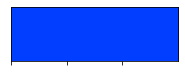

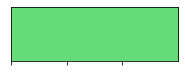

granular_pop:Kinh Vietnamese
superpop:EAS


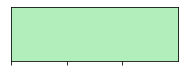

granular_pop:Bengali
superpop:SAS


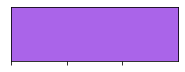

granular_pop:Sri Lankan
superpop:SAS


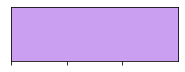

granular_pop:Tuscan
superpop:EUR


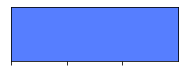

granular_pop:Pathan
superpop:SAS


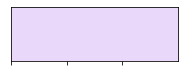

granular_pop:Basque
superpop:EUR


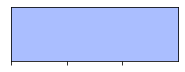

In [35]:
for k, v in colors_Gp_dict.items():
    print(f"granular_pop:{rev_pop_dict[int(k)]}")
    print(f"superpop:{rev_sp_dict[int(gpMap2Sp_Color[k][0])]}")
    sns.palplot(v)
    plt.show()


In [34]:
continentaPops=list(superop_dict.keys())
for i in range(7):
    print(f"{continentaPops[i]} color")
    sns.palplot(colorsSP_dict[i])
    print("gradient color")
    sns.palplot(spGradient[i])
    plt.show()
plt.close('all')

EUR color
gradient color


NameError: name 'spGradient' is not defined

In [ ]:
granular_pop_dict

In [ ]:
spGradient[3]

In [ ]:
cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma','rainbow']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ]


nrows = max(len(cmap_list) for cmap_category, cmap_list in cmaps)
gradient = np.linspace(0, 1, 14)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(cmap_category, cmap_list, nrows):
    fig, axes = plt.subplots(nrows=nrows)
    fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
    axes[0].set_title(cmap_category + ' colormaps', fontsize=14)

    for ax, name in zip(axes, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        pos = list(ax.get_position().bounds)
        x_text = pos[0] - 0.01
        y_text = pos[1] + pos[3]/2.
        fig.text(x_text, y_text, name, va='center', ha='right', fontsize=10)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axes:
        ax.set_axis_off()


for cmap_category, cmap_list in cmaps:
    plot_color_gradients(cmap_category, cmap_list, nrows)

plt.show()

In [ ]:
fig,ax=plt.subplots()
gradient = np.linspace(0, 1, 34)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient, aspect='auto', cmap='tab10')
plt.show()

In [ ]:
gradient

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))

    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]

    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)


def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))

    cmap = grayscale_cmap(cmap)
    grayscale = cmap(np.arange(cmap.N))

    fig, ax = plt.subplots(2, figsize=(6, 2),
                           subplot_kw=dict(xticks=[], yticks=[]))
    ax[0].imshow([colors], extent=[0, 10, 0, 1])
    ax[1].imshow([grayscale], extent=[0, 10, 0, 1])
    plt.show()

In [ ]:
view_colormap('Blues')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.rainbow
bounds = [-1, 2, 5, 7, 12, 15,16,17,60]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal',
             label="Discrete intervals with extend='both' keyword")
plt.show()

In [ ]:
mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

In [ ]:
colors_Gp_dict

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
LinearSegmentedColormap.from_list(name="custom", colors=list(colors_Gp_dict.values()))

In [ ]:
fig,ax=plt.subplots(figsize=(30,14))
ax.imshow(np.ones(shape=(10,317)), cmap=LinearSegmentedColormap.from_list(name="custom", colors=list(colors_Gp_dict.values())))
plt.show()